In [1]:
import seaborn as sns
import tensorflow as tf
import numpy as np
import matplotlib
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import pickle
from sklearn import metrics
import os
import sys

sns.set_style("white")
sns.set_palette("colorblind")

sys.path.insert(0, '/Users/angela/src/private/bias-in-datasets/active_learning/src')
import Evaluate
from Speedup import get_percent_speedup
from Plotter import format_plot_2ys

OURSYSTEM = "Selective-Backprop (Us)"
BASELINE = "Baseline"
RANDOM = "Random"
BASELINE_COLOR ="#009e73"


In [2]:
class LineResult:
    def __init__(self, line_type, epoch, num_backprop, num_skip, loss, time, acc):
        self.line_type = line_type
        self.epoch = epoch
        self.num_backprop = num_backprop
        self.num_skip = num_skip
        self.loss = loss
        self.time = time
        self.acc = acc

    @property
    def is_train(self):
        return self.line_type == "train_debug"

    @property
    def is_test(self):
        return self.line_type == "test_debug"


def parse_line_v1(line):
    vals = line.split(',')
    if "train_debug" in line:
        epoch = int(vals[1])
        num_backprop = int(vals[2])
        loss = float(vals[4])
        time = float(vals[5])
        acc = float(vals[6])
        line_type = "train_debug"
    elif "test_debug" in line:
        epoch = int(vals[1])
        num_backprop = int(vals[2])
        loss = float(vals[3])
        acc = float(vals[4])
        time = float(vals[5])
        line_type = "test_debug"
    else:
        return None
    return LineResult(line_type, epoch, num_backprop, loss, time, acc)


def parse_line_v2(line):
    vals = line.split(',')
    if "train_debug" in line:
        epoch = int(vals[1])
        num_backprop = int(vals[2])
        num_skipped = int(vals[3])
        loss = float(vals[5])
        time = float(vals[6])
        acc = float(vals[7])
        line_type = "train_debug"
    elif "test_debug" in line:
        epoch = int(vals[1])
        num_backprop = int(vals[2])
        num_skipped = int(vals[3])
        loss = float(vals[4])
        acc = float(vals[5])
        time = float(vals[6])
        line_type = "test_debug"
    else:
        return None
    return LineResult(line_type, epoch, num_backprop, num_skipped, loss, time, acc)


def parser_for(filename):
    version = filename.split('_')[-1]
    if version == "v1":
        return parse_line_v1
    if version == "v2":
        return parse_line_v2
    if version == "v3":
        return parse_line_v2
    else:
        Exception("Version cannot be {}".format(version))


def parse_file(filename):
    parser = parser_for(filename)
    with open(filename) as f:
        parsed = [parser(line)
                  for line in f]
    return ([d for d in parsed if d and d.is_train],
            [d for d in parsed if d and d.is_test])



In [25]:
class Config:
    MATCHER = ("^(.*)_(.*)_(.*)_(.*)_(\d+)_(\d*\.?\d*)_(\d*\.?\d*)(_trial\d+)(_seed\d+)?")
    def __init__(self, filename, experiment_name):
        print(filename)

        groups = self.matches(filename)
        self.strategy = groups[0]
        self.dataset = groups[1]
        self.network = groups[2]
        self.top_k = float(groups[3])
        self.pool_size = int(groups[4])
        self.lr = float(groups[5])
        self.decay = groups[6]
        self.seed = None
        self.experiment_name = experiment_name
        unparsed_trial = groups[7]
        self.trial = int(unparsed_trial.strip("_trial"))
        if groups[8]:
            unparsed_seed = groups[8]
            self.seed = int(unparsed_seed.strip("_seed"))
            
    @property
    def label(self):
        if self.strategy == "topk":
            label = "{}, {}, {}, top_{}/{}".format(self.experiment_name,
                                                      self.strategy,
                                                      self.network,
                                                      int(self.top_k),
                                                      self.pool_size)
        elif self.strategy == "lowk":
            label = "{}, {}, {}, lowest_{}/{}".format(self.experiment_name,
                                                      self.strategy,
                                                      self.network,
                                                      int(self.top_k),
                                                      self.pool_size)
        elif self.strategy == "randomk":
            label = "{}, {}, {}, random_{}/{}".format(self.experiment_name,
                                                      self.strategy,
                                                      self.network,
                                                      int(self.top_k),
                                                      self.pool_size)
        elif self.strategy in ["kath-baseline", "kath-biased", "kath-reweighted"]:
            label = "{}, {}, {}, {}/{}".format(self.experiment_name,
                                                      self.strategy,
                                                      self.network,
                                                      int(self.top_k),
                                                      self.pool_size)
        elif self.strategy == "sampling" or self.strategy == "deterministic":
            label = "{}, {}, {}, Min: {}".format(self.experiment_name,
                                                   self.strategy,
                                                   self.network,
                                                   self.top_k) 
        elif self.strategy == "baseline":
            label = "{}, {}, {}".format(self.experiment_name,
                                                   self.strategy,
                                                   self.network) 
        elif self.strategy == "kuangliu":
            label = "{}, original".format(self.experiment_name) 
        elif self.strategy == "debug":
            label = "{}, debug".format(self.experiment_name) 

        #if self.seed:
        #    label += ", seed-{}".format(self.seed)
        #else:
        #    label += ", trial-{}".format(self.trial)
        return label
            
    def matches(self, filename):
        import re
        return (re.match(Config.MATCHER, filename)).groups()
    
def write_file(plot_file_prefix, show=False):

    plot_file = "{}.pdf".format(plot_file_prefix)
    plt.savefig(plot_file)
    
    print(plot_file)
    
    plot_file = "{}.png".format(plot_file_prefix)
    plt.savefig(plot_file, format="png", dpi=1000)
    
    if show:
        plt.show()
        
    plt.clf()

def format_plot(xlabel, ylabel, label_size=10, grid=False):
    plt.tick_params(axis='y', which='major', labelsize=label_size * 1.4)
    plt.tick_params(axis='y', which='minor', labelsize=label_size * 1.2)
    plt.tick_params(axis='x', which='major', labelsize=label_size * 1.4)
    plt.tick_params(axis='x', which='minor', labelsize=label_size * 1.2)

    plt.xlabel(xlabel, fontsize=label_size * 1.6)
    plt.ylabel(ylabel, fontsize=label_size * 1.6)
    plt.tight_layout()
    plt.gca().xaxis.grid(grid)
    plt.gca().yaxis.grid(grid)
    
    leg = plt.legend(loc=0, prop={'size': label_size * 1.4})
    for legobj in leg.legendHandles:
        legobj.set_linewidth(2.0)


In [4]:

def plot(xs_by_config,
         ys_by_config,
         xlabel, ylabel,
         plot_dir,
         smoothing=0,
         lw=1,
         ymin=None,
         ymax=None,
         xmax=None,
         ymarker=None,
         ylog=False,
         annotate_accuracy=False,
         target_errors=None):
    local_xmax = - float("inf")
    local_ymax = - float("inf")
    for config, ys in sorted(ys_by_config.iteritems(), key=lambda x: x[0].top_k):
        if len(ys) == 0:
            print "No elements for {} in {}".format(config.label, ylabel)
            continue
            
        xs = xs_by_config[config]

        for i in range(smoothing):
            xs = [(l+r) / 2. for l, r in zip(xs[:-1], xs[1:])]
            ys = [(l+r) / 2. for l, r in zip(ys[:-1], ys[1:])]
        
        #TODO get label here
        label = config.label
        if annotate_accuracy:
            label += ", Acc:{}".format(max(ys))

        if config.top_k == config.pool_size or config.top_k == 1:
            plt.plot(xs, ys, label=label, linestyle="--", linewidth=lw, alpha=0.7, zorder=0)
        else:
            plt.plot(xs, ys, label=label, linewidth=lw, alpha=0.9, zorder=0)

        if max(xs) > local_xmax:
            local_xmax = max(xs)
        if max(ys) > local_ymax:
            local_ymax = max(ys)
        if xmax:
            plt.xlim(0, xmax)
        if ymin is not None:
            if ymax is not None:
                plt.ylim(ymin, ymax)
            else:
                plt.ylim(ymin, local_ymax)

        
        # Add visual marker where we achieve ymarker accuracy      
        xmarker = Evaluate.find_first_x_at_y(xs, ys, ymarker)
        if xmarker:
            print("xmarker: ", xmarker)
            plt.scatter([xmarker], [ymarker], marker="*", s=50, color="black", zorder=1)
            
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
    
    if len(ys_by_config.keys()) > 0:
        plot_prefix = "{}/{}_{}_{}_lr{}".format(plot_dir,
                                             config.experiment_name,
                                             xlabel,
                                            ylabel,
                                            config.lr)
        if ylog:
            plt.yscale("log")
        format_plot(xlabel, ylabel)
        
        if target_errors:
            for target_error in target_errors:
                plt.axhline(y=target_error, color='gray', linestyle=':', linewidth=0.2)
        write_file(plot_prefix, show=True)




In [5]:
def make_instantaneous(l):
    lcopy = l[:]
    lcopy.insert(0, 0)        
    pairs = zip(lcopy[::1], lcopy[1::1])
    ilist = [j - i for i, j in pairs]
    return ilist

def smooth(l, constant):
    for i in range(constant):
        l = [(l+r) / 2. for l, r in zip(l[:-1], l[1:])]
    return l
            
def plot_experiments(experiment_names,
                     experiments_dir,
                     plot_dir,
                     lrs=None,
                     nets=None,
                     trials=None,
                     sampling_mins=None,
                     smoothing=0,
                     xmax=None,
                     ymin=None,
                     ymax=None,
                     ymarker=None,
                     target_errors = None):
    
    train_num_backprops_by_config = {}
    test_num_backprops_by_config = {}
    test_num_inferences_by_config = {}
    train_losses_by_config = {}
    test_losses_by_config = {}
    test_errors_by_config = {}
    train_accuracies_by_config = {}
    test_accuracies_by_config = {}
    train_accuracies_by_config = {}
    ratio_backpropped_by_config_xs = {}
    ratio_backpropped_by_config_ys = {}

    for experiment_name in experiment_names:
        experiment_dir = os.path.join(experiments_dir, experiment_name)
        for filename in os.listdir(experiment_dir):
            if filename == ".DS_Store" or filename == "pickles" or filename == "sha":
                continue
                
            print(filename)

            filepath = os.path.join(experiment_dir, filename)
            config = Config(filename, experiment_name)
            train_lines, test_lines = parse_file(filepath)
            
            if lrs and config.lr not in lrs:
                continue
            if nets and config.network not in nets:
                continue
            if trials and config.trial not in trials:
                continue
            if sampling_mins and config.top_k not in sampling_mins:
                continue

            train_num_backprops = [l.num_backprop / 1000000. for l in train_lines]
            test_num_backprops = [l.num_backprop / 1000000. for l in test_lines]
            test_num_inferences = [(l.num_backprop + l.num_skip) / 1000000. for l in test_lines]
            train_num_inferences = [(l.num_backprop + l.num_skip) / 1000000. for l in train_lines]

            instantaneous_train_num_backprops = make_instantaneous(train_num_backprops)
            instantaneous_train_num_inferences = make_instantaneous(train_num_inferences)

            train_losses = [l.loss for l in train_lines]
            test_losses = [l.loss for l in test_lines]
            train_accuracies = [l.acc for l in train_lines]
            test_accuracies = [l.acc for l in test_lines]
            test_errors = [100-l.acc for l in test_lines]
            
            ratio_backpropped_ys = smooth([x / float(y) \
                                           for x, y in zip(instantaneous_train_num_backprops,
                                                           instantaneous_train_num_inferences)
                                           if y > 0], 10)
            ratio_backpropped_xs = smooth([l.num_backprop / 1000000. \
                                           for l in train_lines \
                                           if (l.num_backprop + l.num_skip) > 0], 10)
            
            train_num_backprops_by_config[config] = train_num_backprops
            test_num_backprops_by_config[config] = test_num_backprops
            test_num_inferences_by_config[config] = test_num_inferences
            train_losses_by_config[config] = train_losses
            test_losses_by_config[config] = test_losses
            train_accuracies_by_config[config] = train_accuracies
            test_accuracies_by_config[config] = test_accuracies
            test_errors_by_config[config] = test_errors
            ratio_backpropped_by_config_xs[config] = ratio_backpropped_xs
            ratio_backpropped_by_config_ys[config] = ratio_backpropped_ys


    plot(ratio_backpropped_by_config_xs, ratio_backpropped_by_config_ys, "Num Images Backpropped (millions)", "Ratio Backpropped", plot_dir, smoothing, lw=0.8, ymin=0, xmax=xmax)
    #plot(train_num_backprops_by_config, train_losses_by_config, "Num Images Backpropped (millions)", "Training Loss", plot_dir, smoothing, lw=1, xmax=xmax)
    plot(test_num_backprops_by_config, test_accuracies_by_config, "Num Images Backpropped (millions)", "Test Accuracy", plot_dir, smoothing, lw=1, ymin=ymin, ymax=ymax, xmax=xmax, ymarker=ymarker, annotate_accuracy=True)
    plot(test_num_backprops_by_config, test_errors_by_config, "Num Images Backpropped (millions)", "Test Error", plot_dir, smoothing, lw=1, ymin=ymin, ymax=ymax, xmax=xmax,  ymarker=ymarker, ylog=True, target_errors=target_errors)
    plot(test_num_inferences_by_config, test_errors_by_config, "Num Images Forward Propped (millions)", "Test Error", plot_dir, smoothing, lw=1, ymin=ymin, ymax=ymax, xmax=xmax, ymarker=ymarker, ylog=True, target_errors=target_errors)
    plot(test_num_backprops_by_config, test_losses_by_config, "Num Images Backpropped (millions)", "Test Loss", plot_dir, smoothing, lw=1, xmax=xmax)

In [6]:
def plot_percent_speedup(plot_dir, title, nb0, nb1s, nf1s, labels, max_alpha):
    plot_prefix = "{}/{}".format(plot_dir, title)
    if nb0 is None:
        print("Baseline has not reached target error")
        return
    for nb1, nf1, label in zip(nb1s, nf1s, labels):
        if nb1 is None:
            continue
        ys = []
        alphas = range(1, max_alpha + 1)
        for alpha in alphas:
            y = get_percent_speedup(nb0, nb1, nf1, alpha)
            ys.append(y)
        plt.plot(alphas, ys, label=label)

    format_plot("Ratio of Backwards to Forwards Pass Latency", "Speedup Factor")
    write_file(plot_prefix)



In [7]:
def plot_final_error_tradeoff(plot_dir, errors, forwards, labels):
    plot_prefix = "{}/{}".format(plot_dir, "final-error-forwards")
    fig, ax = plt.subplots()
    ax.scatter(forwards, errors)
    for i, txt in enumerate(labels):
        ax.annotate(txt, (forwards[i], errors[i]))
    format_plot("Total # Forwards (millions)", "Final Error")
    ax.set_xlim(left=0)
    write_file(plot_prefix, show=True)

In [8]:
def plot_passes_by_target(plot_dir,
                          nb0s,
                          nb1s,
                          nf1s,
                          labels,
                          targets):
    backwards_by_line = {}
    forwards_by_line = {}
    xs_by_line = {}
    
    backwards_by_line["Baseline"] = []
    forwards_by_line["Baseline"] = []
    xs_by_line["Baseline"] = []
    
    for target in reversed(targets):
        nb0 = nb0s[target]
        
        backwards_by_line["Baseline"].append(nb0)
        forwards_by_line["Baseline"].append(nb0)
        xs_by_line["Baseline"].append(target)

        if nb0 is None:
            continue

        for nb1, nf1, label in zip(nb1s[target], nf1s[target], labels):
            if nb1 is None:
                continue
            if label not in backwards_by_line.keys():
                backwards_by_line[label] = []
                forwards_by_line[label] = []
                xs_by_line[label] = []
            backwards_by_line[label].append(nb1)
            forwards_by_line[label].append(nf1)
            xs_by_line[label].append(target)

    for ys_dict, y_label in zip([backwards_by_line, forwards_by_line],
                                ["Backwards Passes", "Forwards Passes"]):
        max_x = 0
        min_x = float('Inf')
        for label, ys in ys_dict.iteritems():
            xs = xs_by_line[label]
            plt.plot(xs, ys, label=label)
        if max(xs) > max_x:
            max_x = max(xs)
        if min(xs) < min_x:
            min_x = min(xs)
        plt.axhline(y=0, color='gray', linestyle=':', linewidth=1)
        format_plot("Target Error", y_label)
        plot_prefix = "{}/target-vs-{}".format(plot_dir, y_label)
        plt.xlim(max_x, min_x)
        write_file(plot_prefix)
        plt.clf()

In [9]:
def plot_percent_speedup_by_alphas(plot_dir, label_idx, label, nb0s, nb1s, nf1s, targets, alphas=[3,10]):
    max_y = 0
    for alpha in alphas:
        xs = []
        ys = []
        for target in reversed(targets):
            nb0 = nb0s[target]
            if nb0 is None:
                continue
            nb1 = nb1s[target][label_idx]
            nf1 = nf1s[target][label_idx]
            if nb1 is None:
                continue
            y = get_percent_speedup(nb0, nb1, nf1, alpha)
            xs.append(target)
            ys.append(y)
        if max(ys) > max_y:
            max_y = max(ys)
        plt.plot(xs, ys, marker='o', label="Backwards is {}X More costly".format(alpha))
        
    format_plot("Target Error", "Speedup Factor")
    plt.xlim(max(targets), min(targets))
    plt.ylim(0, int(max_y) + 1)
    plot_prefix = "{}/{}".format(plot_dir, "speedups{}".format(label))
    write_file(plot_prefix)

In [10]:

def plot_percent_speedup_by_alpha(plot_dir,
                                  title,
                                  nb0s,
                                  nb1s,
                                  nf1s,
                                  labels,
                                  targets,
                                  alpha):
    speedups_by_line = {}
    xs_by_line = {}

    for target in reversed(targets):
        nb0 = nb0s[target]
        if nb0 is None:
            continue
        for nb1, nf1, label in zip(nb1s[target], nf1s[target], labels):
            if nb1 is None:
                continue
            if label not in speedups_by_line.keys():
                speedups_by_line[label] = []
                xs_by_line[label] = []
            y = get_percent_speedup(nb0, nb1, nf1, alpha)
            speedups_by_line[label].append(y)
            xs_by_line[label].append(target)

    max_x = 0
    min_x = float('Inf')
    for label, ys in speedups_by_line.iteritems():
        xs = xs_by_line[label]
        plt.plot(xs, ys, label=label)
        if max(xs) > max_x:
            max_x = max(xs)
        if min(xs) < min_x:
            min_x = min(xs)
    plt.axhline(y=0, color='gray', linestyle=':', linewidth=1)
    format_plot("Target Error", "Speedup Factor")
    plt.xlim(max_x, min_x)
    plot_prefix = "{}/{}".format(plot_dir, title)
    write_file(plot_prefix)
        

In [11]:
# Glue for plot_final_error_tradeoff and plot_percent_speedup

def plot_wallclock(plot_dir, target_errors, experimental_names, baseline_name, experimental_labels, final_bp, max_alpha):
    nb0s = {}
    nb1s = {}
    nf1s = {}

    final_errors = []
    final_nfs = []
    final_labels = []

    # Experimental
    for experimental_name, experimental_label in zip(experimental_names, experimental_labels):
        data = Evaluate.evaluate_file(experimental_name, target_errors, [final_bp])
        for target_error in target_errors:
            if target_error not in nb1s.keys():
                nb1s[target_error] = []
                nf1s[target_error] = []
            nb1s[target_error].append(data["target_errors"][target_error]["num_backwards"])
            nf1s[target_error].append(data["target_errors"][target_error]["num_forwards"])
        final_error = data["target_backwards"][final_bp]["error"]
        if final_error:
            final_errors.append(final_error)
            final_labels.append(experimental_label)
            final_nfs.append(data["target_backwards"][final_bp]["num_forwards"])
        
    # Baseline
    data = Evaluate.evaluate_file(baseline_name, target_errors, [final_bp])
    for target_error in target_errors:
        nb0s[target_error] = data["target_errors"][target_error]["num_backwards"]
    final_error = data["target_backwards"][final_bp]["error"]
    if final_error:
        final_errors.append(final_error)
        final_labels.append("Baseline")
        final_nfs.append(data["target_backwards"][final_bp]["num_forwards"])
    
    # Plot final error
    plot_final_error_tradeoff(plot_dir, final_errors, final_nfs, final_labels)
    
    # Plot forwards/backwards by target error
    plot_passes_by_target(plot_dir, nb0s, nb1s, nf1s, experimental_labels, target_errors)
    
    # Plot speedup by cost_ratio
    cost_ratios = []
    for alpha in range(max_alpha):
        title = "alpha{}".format(alpha)
        plot_percent_speedup_by_alpha(plot_dir,
                                      title,
                                      nb0s,
                                      nb1s,
                                      nf1s,
                                      experimental_labels,
                                      target_errors,
                                      alpha)
        
    for i, label in enumerate(experimental_labels):
        plot_percent_speedup_by_alphas(plot_dir, i, label, nb0s, nb1s, nf1s, target_errors)


sampling_cifar10_mobilenetv2_0.1_128_0.0_0.0005_trial1_seed1337_v2
sampling_cifar10_mobilenetv2_0.1_128_0.0_0.0005_trial1_seed1337_v2
sampling_cifar10_mobilenetv2_1_128_0.0_0.0005_trial1_seed1337_v2
sampling_cifar10_mobilenetv2_1_128_0.0_0.0005_trial1_seed1337_v2
sampling_cifar10_mobilenetv2_0.1_128_0.0_0.0005_trial1_seed1337_v2
sampling_cifar10_mobilenetv2_0.1_128_0.0_0.0005_trial1_seed1337_v2
sampling_cifar10_mobilenetv2_1_128_0.0_0.0005_trial1_seed1337_v2
sampling_cifar10_mobilenetv2_1_128_0.0_0.0005_trial1_seed1337_v2
sampling_cifar10_mobilenetv2_0_128_1024_0.0005_trial1_seed1337_v2
sampling_cifar10_mobilenetv2_0_128_1024_0.0005_trial1_seed1337_v2
kath-baseline_cifar10_mobilenetv2_1_128_1024_0.0005_trial1_seed1337_v2
kath-baseline_cifar10_mobilenetv2_1_128_1024_0.0005_trial1_seed1337_v2
kath-biased_cifar10_mobilenetv2_1_128_1024_0.0005_trial1_seed1337_v2
kath-biased_cifar10_mobilenetv2_1_128_1024_0.0005_trial1_seed1337_v2
kath-biased_cifar10_mobilenetv2_1_128_1028_0.0005_trial1_see

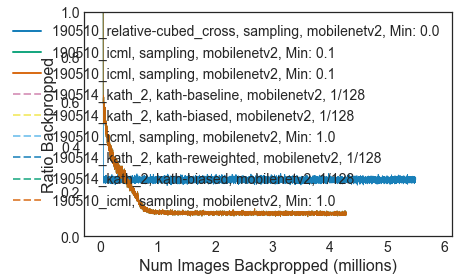

No elements for 190514_kath_2, kath-reweighted, mobilenetv2, 1/128 in Test Accuracy
../plots/190514_relative//190510_icml_Num Images Backpropped (millions)_Test Accuracy_lr0.0.pdf


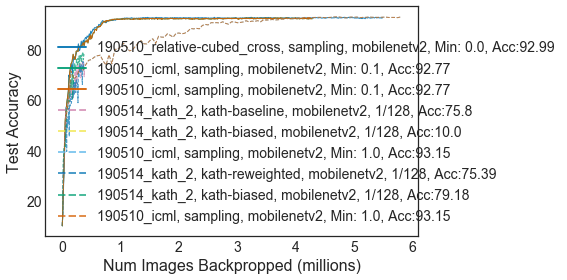

No elements for 190514_kath_2, kath-reweighted, mobilenetv2, 1/128 in Test Error
../plots/190514_relative//190510_icml_Num Images Backpropped (millions)_Test Error_lr0.0.pdf


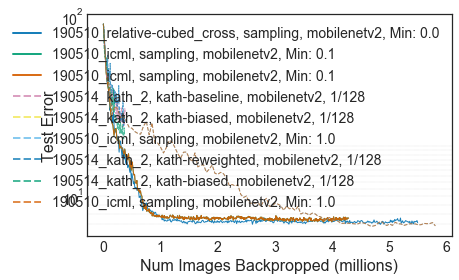

No elements for 190514_kath_2, kath-reweighted, mobilenetv2, 1/128 in Test Error
../plots/190514_relative//190510_icml_Num Images Forward Propped (millions)_Test Error_lr0.0.pdf


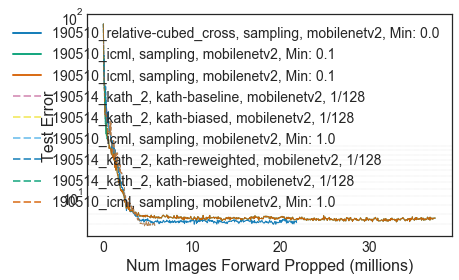

No elements for 190514_kath_2, kath-reweighted, mobilenetv2, 1/128 in Test Loss
../plots/190514_relative//190510_icml_Num Images Backpropped (millions)_Test Loss_lr0.0.pdf


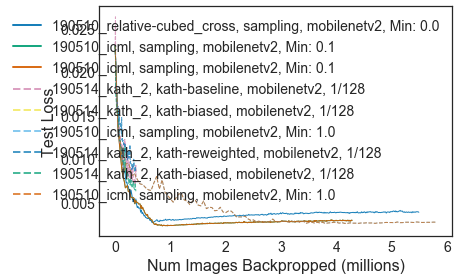

Final error: 6.88, Forwards: 4.7, Backwards: 4.7
Final error: 7.59, Forwards: 5.85, Backwards: 1.073771
Final error: 7.16, Forwards: 5.4, Backwards: 1.389129
Final error: 28.07, Forwards: 0.237056, Backwards: 0.237056


IOError: [Errno 2] No such file or directory: '../data/output/cifar10/190514_relative/sampling_cifar10_mobilenetv2_1_128_0.0_0.0005_trial1_seed1337_v2'

<Figure size 432x288 with 0 Axes>

In [30]:
# CIFAR10


plot_home_dir = "../plots"
experiment_dir = "../data/output/cifar10/"

plot_dir = "{}/190514_relative/".format(plot_home_dir)
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)
    
experiment_names = ["190510_icml", "190510_icml", "190510_relative-cubed_cross", "190514_kath_2"]
filenames = ["sampling_cifar10_mobilenetv2_1_128_0.0_0.0005_trial1_seed1337_v2",
             "sampling_cifar10_mobilenetv2_0.1_128_0.0_0.0005_trial1_seed1337_v2",
             "sampling_cifar10_mobilenetv2_0_128_1024_0.0005_trial1_seed1337_v2",
             "kath-baseline_cifar10_mobilenetv2_1_128_1024_0.0005_trial1_seed1337_v2",
             "kath-biased_cifar10_mobilenetv2_1_128_1024_0.0005_trial1_seed1337_v2",
             "kath-reweighted_cifar10_mobilenetv2_1_128_1024_0.0005_trial1_seed1337_v2",
            ]
candidate_labels = ["Baseline",
                    "SB-ICML",
                    "SB-Relative-Cubed-1024",
                    "Kath-Baseline",
                    "Kath-Biased",
                    "Kath-Reweighted",
                   ]

experimental_filepaths = []
experimental_labels = []
baseline_filepath = None
target_errors = range(7, 20)

if True:
    plot_experiments(experiment_names,
                     experiment_dir,
                     plot_dir,
                     nets=["mobilenetv2"],
                     trials=[1],
                     target_errors = target_errors)
if True:
    for experiment_name, filename, experimental_label in zip(experiment_names, filenames, candidate_labels):
        filedir = os.path.join(experiment_dir, experiment_name)
        filepath = os.path.join(filedir, filename)
        experimental_filepaths.append(filepath)
        experimental_labels.append(experimental_label)

    experiment_name = "190514_relative"
    filepath = os.path.join(experiment_dir,
                            experiment_name, 
                            "sampling_cifar10_mobilenetv2_1_128_0.0_0.0005_trial1_seed1337_v2")
    baseline_filepath = filepath

    max_alpha = 10
    final_bps = 4.3
    plot_wallclock(plot_dir, target_errors, experimental_filepaths, baseline_filepath, experimental_labels, final_bps, max_alpha)



sampling_mnist_LeNet-5_0_128_1024_0.0005_trial1_seed1337_v2
sampling_mnist_LeNet-5_0_128_1024_0.0005_trial1_seed1337_v2
sampling_mnist_LeNet-5_1_128_1024_0.0005_trial1_seed1337_v2
sampling_mnist_LeNet-5_1_128_1024_0.0005_trial1_seed1337_v2
sampling_mnist_LeNet-5_0_128_1024_0.0005_trial1_seed1337_v2
sampling_mnist_LeNet-5_0_128_1024_0.0005_trial1_seed1337_v2
sampling_mnist_LeNet-5_1_128_1024_0.0005_trial1_seed1337_v2
sampling_mnist_LeNet-5_1_128_1024_0.0005_trial1_seed1337_v2
sampling_mnist_lecun5_0_128_1024_0.0005_trial1_seed1337_v2
sampling_mnist_lecun5_0_128_1024_0.0005_trial1_seed1337_v2
sampling_mnist_lecun5_0_128_1024_0.0005_trial1_seed1337_v2
sampling_mnist_lecun5_0_128_1024_0.0005_trial1_seed1337_v2
kath-baseline_mnist_lecun5_1_128_1024_0.0005_trial1_seed1337_v2
kath-baseline_mnist_lecun5_1_128_1024_0.0005_trial1_seed1337_v2
kath-biased_mnist_lecun5_1_128_1024_0.0005_trial1_seed1337_v2
kath-biased_mnist_lecun5_1_128_1024_0.0005_trial1_seed1337_v2
kath-reweighted_mnist_lecun5_1_1

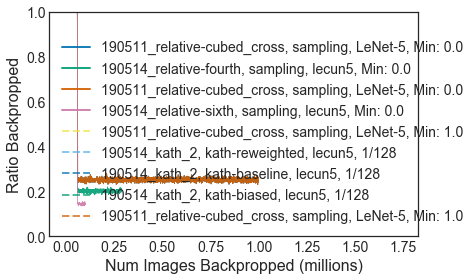

../plots/190511_mnist//190511_relative-cubed_cross_Num Images Backpropped (millions)_Test Accuracy_lr1024.0.pdf


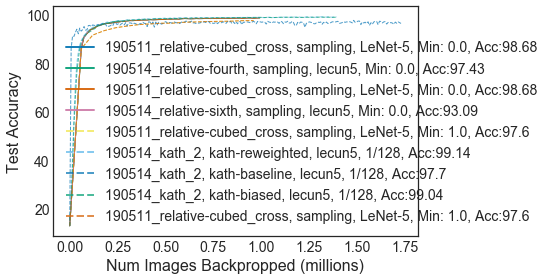

../plots/190511_mnist//190511_relative-cubed_cross_Num Images Backpropped (millions)_Test Error_lr1024.0.pdf


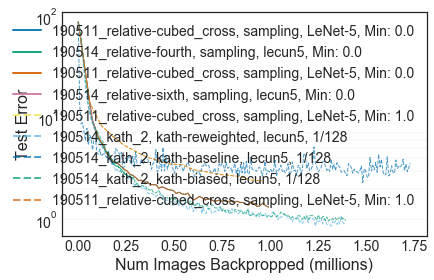

../plots/190511_mnist//190511_relative-cubed_cross_Num Images Forward Propped (millions)_Test Error_lr1024.0.pdf


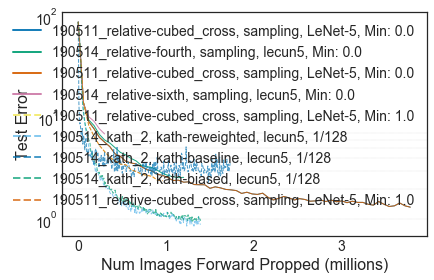

../plots/190511_mnist//190511_relative-cubed_cross_Num Images Backpropped (millions)_Test Loss_lr1024.0.pdf


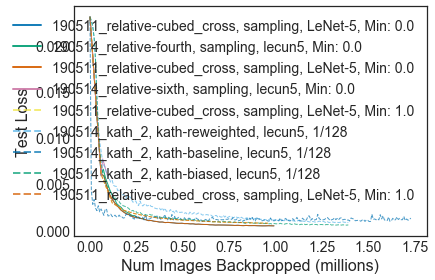

Final error: 1.32, Forwards: 3.779906, Backwards: 0.991923
Final error: 2.4, Forwards: 0.96, Backwards: 0.96
Final error: 2.59, Forwards: 1.14, Backwards: 0.27593
Final error: 6.91, Forwards: 0.3, Backwards: 0.094408
Final error: 0.89, Forwards: 1.235456, Backwards: 1.235456
Final error: 2.4, Forwards: 0.96, Backwards: 0.96
../plots/190511_mnist//final-error-forwards.pdf


<Figure size 432x288 with 0 Axes>

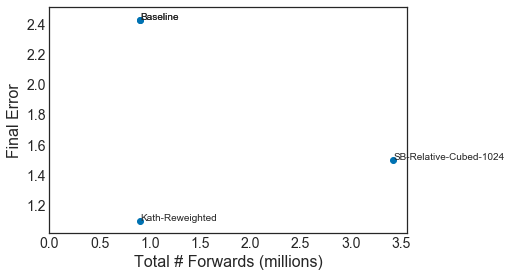

../plots/190511_mnist//target-vs-Backwards Passes.pdf
../plots/190511_mnist//target-vs-Forwards Passes.pdf
../plots/190511_mnist//alpha0.pdf
../plots/190511_mnist//alpha1.pdf
../plots/190511_mnist//alpha2.pdf
../plots/190511_mnist//alpha3.pdf
../plots/190511_mnist//alpha4.pdf
../plots/190511_mnist//alpha5.pdf
../plots/190511_mnist//alpha6.pdf
../plots/190511_mnist//alpha7.pdf
../plots/190511_mnist//alpha8.pdf
../plots/190511_mnist//alpha9.pdf
../plots/190511_mnist//speedupsSB-Relative-Cubed-1024.pdf
../plots/190511_mnist//speedupsBaseline.pdf
../plots/190511_mnist//speedupsSB-Relative-Fourth-1024.pdf
../plots/190511_mnist//speedupsSB-Relative-Sixth-1024.pdf
../plots/190511_mnist//speedupsKath-Reweighted.pdf


<Figure size 432x288 with 0 Axes>

In [38]:
# MNIST

plot_home_dir = "../plots"
experiment_dir = "../data/output/mnist/"

plot_dir = "{}/190511_mnist/".format(plot_home_dir)
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)
    
experiment_names = ["190511_relative-cubed_cross", "190511_relative-cubed_cross", "190514_relative-fourth", "190514_relative-sixth", "190514_kath_2"]
filenames = ["sampling_mnist_LeNet-5_0_128_1024_0.0005_trial1_seed1337_v2",
             "sampling_mnist_LeNet-5_1_128_1024_0.0005_trial1_seed1337_v2",
             "sampling_mnist_lecun5_0_128_1024_0.0005_trial1_seed1337_v2",
             "sampling_mnist_lecun5_0_128_1024_0.0005_trial1_seed1337_v2",
             "kath-reweighted_mnist_lecun5_1_128_1024_0.0005_trial1_seed1337_v2"
            ]
candidate_labels = [
                    #"SB-ICML",
                    #"SB-Relative-1024",
                    "SB-Relative-Cubed-1024",
                    "Baseline",
                    "SB-Relative-Fourth-1024",
                    "SB-Relative-Sixth-1024",
                    "Kath-Reweighted"
                   ]

experimental_filepaths = []
experimental_labels = []
baseline_filepath = None
target_errors = range(1, 8)

if True:
    plot_experiments(experiment_names,
                     experiment_dir,
                     plot_dir,
                     trials=[1],
                     target_errors = target_errors)
if True:
    for experiment_name, filename, experimental_label in zip(experiment_names, filenames, candidate_labels):
        filedir = os.path.join(experiment_dir, experiment_name)
        filepath = os.path.join(filedir, filename)
        experimental_filepaths.append(filepath)
        experimental_labels.append(experimental_label)

    experiment_name = "190511_relative-cubed_cross"
    filepath = os.path.join(experiment_dir, experiment_name, 
                            "sampling_mnist_LeNet-5_1_128_1024_0.0005_trial1_seed1337_v2")
    baseline_filepath = filepath

    max_alpha = 10
    final_bps = .9
    plot_wallclock(plot_dir, target_errors, experimental_filepaths, baseline_filepath, experimental_labels, final_bps, max_alpha)



In [33]:
# CIFAR100

plot_home_dir = "../plots"
experiment_dir = "../data/output/cifar100/"

plot_dir = "{}/190514_cifar100/".format(plot_home_dir)
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)
    
experiment_names = ["190514_4_relative-cubed_cross", "190514_4_relative-cubed_cross"]
filenames = ["sampling_cifar100_wideresnet_0_64_0.0_0.0005_trial1_seed1337_v2",
             "sampling_cifar100_wideresnet_1_64_0.0_0.0005_trial1_seed1337_v2",
            ]
candidate_labels = [
                    "SB-Relative-Cubed-1024",
                    "Baseline",
                   ]

plot_dir = "{}/190514_cifar100/{}".format(plot_home_dir, experiment_names[0])
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)
    
experimental_filepaths = []
experimental_labels = []
baseline_filepath = None
target_errors = range(25, 40)

if True:
    plot_experiments(experiment_names,
                     experiment_dir,
                     plot_dir,
                     trials=[1],
                     target_errors = target_errors)
if True:
    for experiment_name, filename, experimental_label in zip(experiment_names, filenames, candidate_labels):
        filedir = os.path.join(experiment_dir, experiment_name)
        filepath = os.path.join(filedir, filename)
        experimental_filepaths.append(filepath)
        experimental_labels.append(experimental_label)

    experiment_name = experiment_names[0]
    filepath = os.path.join(experiment_dir, experiment_name, 
                            "sampling_cifar100_wideresnet_1_64_0.0_0.0005_trial1_seed1337_v2")
    baseline_filepath = filepath

    max_alpha = 10
    final_bps = .9
    plot_wallclock(plot_dir, target_errors, experimental_filepaths, baseline_filepath, experimental_labels, final_bps, max_alpha)



sampling_cifar100_wideresnet_0_64_0.0_0.0005_trial1_seed1337_v2
sampling_cifar100_wideresnet_0_64_0.0_0.0005_trial1_seed1337_v2
sampling_cifar100_wideresnet_1_64_0.0_0.0005_trial1_seed1337_v2
sampling_cifar100_wideresnet_1_64_0.0_0.0005_trial1_seed1337_v2
sampling_cifar100_wideresnet_0_64_0.0_0.0005_trial1_seed1337_v2
sampling_cifar100_wideresnet_0_64_0.0_0.0005_trial1_seed1337_v2
sampling_cifar100_wideresnet_1_64_0.0_0.0005_trial1_seed1337_v2
sampling_cifar100_wideresnet_1_64_0.0_0.0005_trial1_seed1337_v2


KeyboardInterrupt: 

sampling_imagenet_resnet_0_128_0.0_0.0001_trial1_seed1337_v2
sampling_imagenet_resnet_0_128_0.0_0.0001_trial1_seed1337_v2
sampling_imagenet_resnet_1_128_0.0_0.0001_trial1_seed1337_v2
sampling_imagenet_resnet_1_128_0.0_0.0001_trial1_seed1337_v2
../plots/190513_imagenet//190513_relative-cubed_cross_Num Images Backpropped (millions)_Ratio Backpropped_lr0.0.pdf


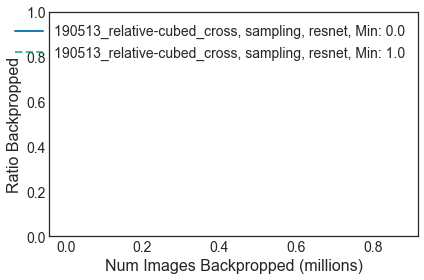

../plots/190513_imagenet//190513_relative-cubed_cross_Num Images Backpropped (millions)_Test Accuracy_lr0.0.pdf


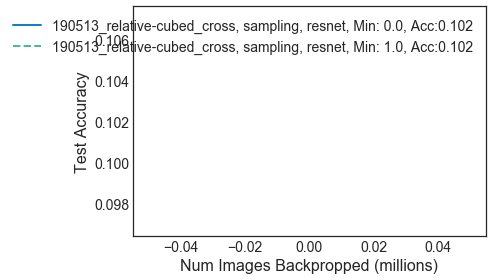

../plots/190513_imagenet//190513_relative-cubed_cross_Num Images Backpropped (millions)_Test Error_lr0.0.pdf


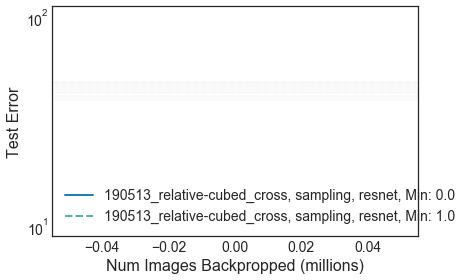

../plots/190513_imagenet//190513_relative-cubed_cross_Num Images Forward Propped (millions)_Test Error_lr0.0.pdf


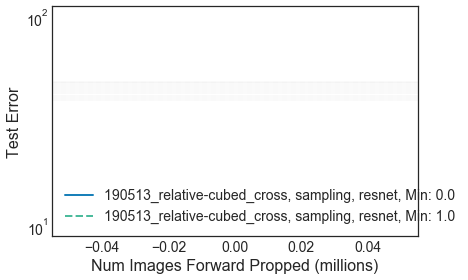

../plots/190513_imagenet//190513_relative-cubed_cross_Num Images Backpropped (millions)_Test Loss_lr0.0.pdf


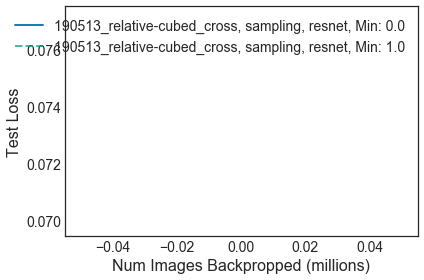

Final error: 99.898, Forwards: 0.0, Backwards: 0.0
Final error: 99.898, Forwards: 0.0, Backwards: 0.0
../plots/190513_imagenet//final-error-forwards.pdf


<Figure size 432x288 with 0 Axes>

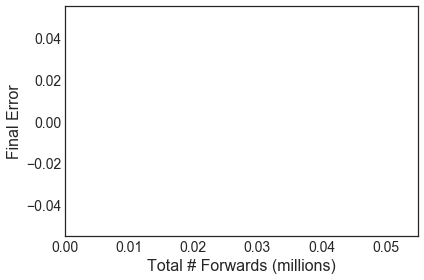

../plots/190513_imagenet//target-vs-Backwards Passes.pdf
../plots/190513_imagenet//target-vs-Forwards Passes.pdf


ValueError: Axis limits cannot be NaN or Inf

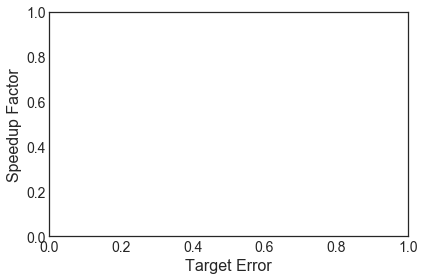

In [72]:
# ImageNet

plot_home_dir = "../plots"
experiment_dir = "../data/output/imagenet/"

plot_dir = "{}/190513_imagenet/".format(plot_home_dir)
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)
    
experiment_names = ["190513_relative-cubed_cross"]
filenames = ["sampling_imagenet_resnet_0_128_0.0_0.0001_trial1_seed1337_v2",
             "sampling_imagenet_resnet_1_128_0.0_0.0001_trial1_seed1337_v2",
            ]
candidate_labels = [
                    "SB-Relative-Cubed-1024",
                    "Baseline",
                   ]

experimental_filepaths = []
experimental_labels = []
baseline_filepath = None
target_errors = range(40, 50)

if True:
    plot_experiments(experiment_names,
                     experiment_dir,
                     plot_dir,
                     trials=[1],
                     target_errors = target_errors)
if True:
    for experiment_name, filename, experimental_label in zip(experiment_names, filenames, candidate_labels):
        filedir = os.path.join(experiment_dir, experiment_name)
        filepath = os.path.join(filedir, filename)
        experimental_filepaths.append(filepath)
        experimental_labels.append(experimental_label)

    experiment_name = "190513_relative-cubed_cross"
    filepath = os.path.join(experiment_dir, experiment_name, 
                            "sampling_imagenet_resnet_1_128_0.0_0.0001_trial1_seed1337_v2")
    baseline_filepath = filepath

    max_alpha = 10
    final_bps = .9
    plot_wallclock(plot_dir, target_errors, experimental_filepaths, baseline_filepath, experimental_labels, final_bps, max_alpha)



sampling_svhn_resnet_0_128_1024_0.0005_trial1_seed1337_v2
sampling_svhn_resnet_0_128_1024_0.0005_trial1_seed1337_v2
sampling_svhn_resnet_1_128_1024_0.0005_trial1_seed1337_v2
sampling_svhn_resnet_1_128_1024_0.0005_trial1_seed1337_v2
sampling_svhn_resnet_0_128_1024_0.0005_trial1_seed1337_v2
sampling_svhn_resnet_0_128_1024_0.0005_trial1_seed1337_v2
sampling_svhn_resnet_1_128_1024_0.0005_trial1_seed1337_v2
sampling_svhn_resnet_1_128_1024_0.0005_trial1_seed1337_v2
../plots/190514_svhn//190514_2_Num Images Backpropped (millions)_Ratio Backpropped_lr1024.0.pdf


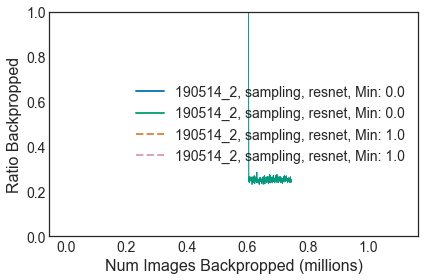

../plots/190514_svhn//190514_2_Num Images Backpropped (millions)_Test Accuracy_lr1024.0.pdf


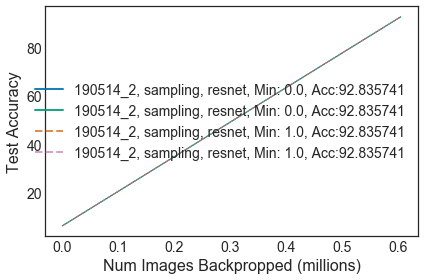

../plots/190514_svhn//190514_2_Num Images Backpropped (millions)_Test Error_lr1024.0.pdf


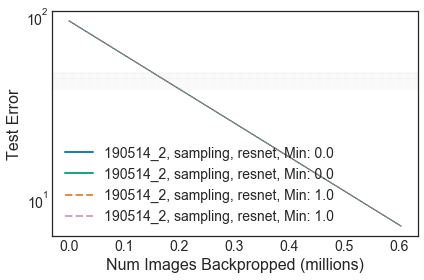

../plots/190514_svhn//190514_2_Num Images Forward Propped (millions)_Test Error_lr1024.0.pdf


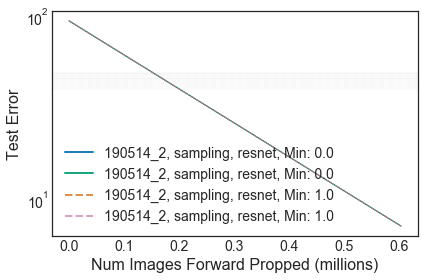

../plots/190514_svhn//190514_2_Num Images Backpropped (millions)_Test Loss_lr1024.0.pdf


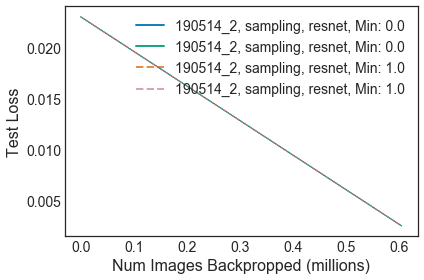

Final error: 7.164259, Forwards: 0.604388, Backwards: 0.604388
Final error: 7.164259, Forwards: 0.604388, Backwards: 0.604388
Final error: 7.164259, Forwards: 0.604388, Backwards: 0.604388
../plots/190514_svhn//final-error-forwards.pdf


<Figure size 432x288 with 0 Axes>

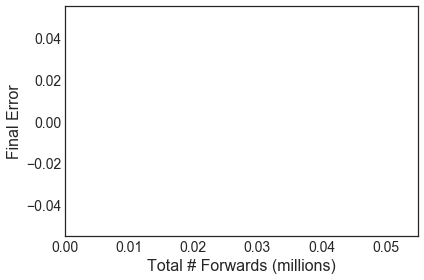

../plots/190514_svhn//target-vs-Backwards Passes.pdf
../plots/190514_svhn//target-vs-Forwards Passes.pdf
../plots/190514_svhn//alpha0.pdf
../plots/190514_svhn//alpha1.pdf
../plots/190514_svhn//alpha2.pdf
../plots/190514_svhn//alpha3.pdf
../plots/190514_svhn//alpha4.pdf
../plots/190514_svhn//alpha5.pdf
../plots/190514_svhn//alpha6.pdf
../plots/190514_svhn//alpha7.pdf
../plots/190514_svhn//alpha8.pdf
../plots/190514_svhn//alpha9.pdf
../plots/190514_svhn//speedupsSB-Relative-Cubed-1024.pdf
../plots/190514_svhn//speedupsBaseline.pdf


<Figure size 432x288 with 0 Axes>

In [22]:
# svhn

plot_home_dir = "../plots"
experiment_dir = "../data/output/svhn/"

plot_dir = "{}/190514_svhn/".format(plot_home_dir)
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)
    
experiment_names = ["190514_2", "190514_2"]
filenames = ["sampling_svhn_resnet_0_128_1024_0.0005_trial1_seed1337_v2",
             "sampling_svhn_resnet_1_128_1024_0.0005_trial1_seed1337_v2",
            ]
candidate_labels = [
                    "SB-Relative-Cubed-1024",
                    "Baseline",
                   ]

experimental_filepaths = []
experimental_labels = []
baseline_filepath = None
target_errors = range(40, 50)

if True:
    plot_experiments(experiment_names,
                     experiment_dir,
                     plot_dir,
                     trials=[1],
                     target_errors = target_errors)
if True:
    for experiment_name, filename, experimental_label in zip(experiment_names, filenames, candidate_labels):
        filedir = os.path.join(experiment_dir, experiment_name)
        filepath = os.path.join(filedir, filename)
        experimental_filepaths.append(filepath)
        experimental_labels.append(experimental_label)

    experiment_name = experiment_names[0]
    filepath = os.path.join(experiment_dir, experiment_name, filenames[1])
    baseline_filepath = filepath

    max_alpha = 10
    final_bps = .9
    plot_wallclock(plot_dir, target_errors, experimental_filepaths, baseline_filepath, experimental_labels, final_bps, max_alpha)

